In [9]:
#Geeks for Geeks Testing


import os
newestModel = True #If this is set to true it will use the newest model in the models folder and ignore modelToTest
modelToTest = '2023-12-04_18-42-35-989228'
threads = 16 #Number of threads to use for multithreaded tasks
pathToModelFolder = '/mnt/SPDrive/SPGenerations/Models'
#pathToDataFolder = '~/SPDataset/MiniTestingDataset'
#a folder inthe models folder contains the following files: model.h5, tokenizer.json commitHash.txt (For SCA-Tokenizer)
useCurrentSCATokenizer = '/home/mcall/SPGit/Model-Generation/SCA-Tokenizer' #If this is set to anything other than '' it will use the current SCA-Token in the SCA-Token folder and ignore the modelToTest
pathToGeeks4GeeksData = '/mnt/SPDrive/Geeks4GeeksData/FileOutput/'

In [10]:
import os
import pickle
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import json
import threading as th
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys
import subprocess
import time
import datetime
import random
import math
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import tokenizer_from_json
sys.path.append('./SCA-Tokenizer/')
import TokenizerManager
catigoryInputModel = False


def homePath(path):
    if path[0] == '~':
        return os.path.join(os.path.expanduser("~"), path.strip("~/"))
    else:
        return path

pathToModelFolder = homePath(pathToModelFolder)

def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()


def searchFileName(path, fileName):
    filesToDo = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file == fileName:
                    filesToDo.append(os.path.join(root, file).split(path)[1])
    return filesToDo

In [11]:
#File Loading


if newestModel:
    models = os.listdir(pathToModelFolder)
    models.sort()
    modelToTest = models[-1]
    print("Using newest model: " + modelToTest)
else:
    print("Using model: " + modelToTest)
model = load_model(pathToModelFolder + '/' +modelToTest + '/model.h5')
print (model.summary())

#load tokenizer from json that used the .tokenizer.save() function
with open(pathToModelFolder + '/' + modelToTest + '/tokenizer.json') as f:
    tokenizerModel = tokenizer_from_json(f.read())


Using newest model: 2024-02-13_12-33-14-841992
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 2048)         1638400   
                                                                 
 conv1d (Conv1D)             (None, 498, 2048)         12584960  
                                                                 
 global_max_pooling1d (Glob  (None, 2048)              0         
 alMaxPooling1D)                                                 
                                                                 
 reshape (Reshape)           (None, 1, 2048)           0         
                                                                 
 bidirectional (Bidirection  (None, 1, 2048)           25174016  
 al)          

In [74]:
#get all subfolders in the pathToGeeks4Geeks folder
subFolders = os.listdir(pathToGeeks4GeeksData)
#make problems dict
problems = {}
for folder in subFolders:
    if os.path.isdir(pathToGeeks4GeeksData + '/' + folder):
        problems[folder] = []
        


#load all files into the problem in the problems list
for problem in problems:
    #make a dict for all users
    users = {}
    subFolders = os.listdir(pathToGeeks4GeeksData + '/' + problem + '/')
    for folder in subFolders:
        if os.path.isdir(pathToGeeks4GeeksData + '/' + problem + '/' + folder):
            #make a list for all files
            fileConcents = []
            files = []
            #get all files in the folder
            filesInFolder = os.listdir(pathToGeeks4GeeksData + '/' + problem + '/' + folder)
            #sort the files
            filesInFolder.sort()
            #add all files to the list
            for file in filesInFolder:
                correct = False
                if file.endswith('_correct.txt'):
                    correct = True
                try:
                    fileConcents.append([correct, open(pathToGeeks4GeeksData + '/' + problem + '/' + folder + '/' + file).read()])
                except:
                    print ('Error reading file: ' + pathToGeeks4GeeksData + '/' + problem + '/' + folder + '/' + file)
            users[folder] = fileConcents


    problems[problem] = users



Error reading file: /mnt/SPDrive/Geeks4GeeksData/FileOutput//704140/juandavid34v4/3_correct.txt
Error reading file: /mnt/SPDrive/Geeks4GeeksData/FileOutput//704140/juliotorresmoreno/1_incorrect.txt
Error reading file: /mnt/SPDrive/Geeks4GeeksData/FileOutput//704140/juliotorresmoreno/2_incorrect.txt
Error reading file: /mnt/SPDrive/Geeks4GeeksData/FileOutput//701294/rajkuma49wy/0_incorrect.txt
Error reading file: /mnt/SPDrive/Geeks4GeeksData/FileOutput//701294/rajkuma49wy/1_incorrect.txt
Error reading file: /mnt/SPDrive/Geeks4GeeksData/FileOutput//701294/rajkuma49wy/2_incorrect.txt
Error reading file: /mnt/SPDrive/Geeks4GeeksData/FileOutput//701294/rajkuma49wy/3_incorrect.txt
Error reading file: /mnt/SPDrive/Geeks4GeeksData/FileOutput//701189/sidhantmae6t1/1_incorrect.txt
Error reading file: /mnt/SPDrive/Geeks4GeeksData/FileOutput//701189/sidhantmae6t1/2_incorrect.txt
Error reading file: /mnt/SPDrive/Geeks4GeeksData/FileOutput//701189/sidhantmae6t1/3_incorrect.txt
Error reading file: /m

In [13]:
listOfCorrectAnswerValues = []
listOfIncorrectAnswerValues = []
listOfIndeterminateAnswerValues = []

problemResultsLazyWay = {}

In [14]:
#Simple test, check the first answer and last answer and see if the last answer is higher
max_length = model.layers[0].input_shape[0][1]
print (max_length)



def testUser(user):
    if user[0][0]:
        return None
    #expected input, a list of lists, each list is [boolifCorrect, answer]
    #expected output, a bool if the last answer is higher than the first answer
    #get the first answer that is incorrect
    firstAnswer = ''
    for answer in user:
        if not answer[0]:
            firstAnswer = answer[1]
            break
    #get the last answer that is correct
    lastAnswer = ''
    for answer in reversed(user):
        if answer[0]:
            lastAnswer = answer[1]
            break

    
    firstAnswerScore = 0
    lastAnswerScore = 0


    #convert both to model ready input
    if (firstAnswer == '') or (lastAnswer == ''):
        return None
    firstAnswer = TokenizerManager.tokenStartFromString(firstAnswer, tokenizerModel)
    lastAnswer = TokenizerManager.tokenStartFromString(lastAnswer, tokenizerModel)
    #pad both
    firstAnswer = pad_sequences([firstAnswer[0]], maxlen= max_length)
    lastAnswer = pad_sequences([lastAnswer[0]], maxlen=max_length)
    #get the scores
    firstAnswerScore = model.predict([firstAnswer], verbose=0)
    lastAnswerScore = model.predict([lastAnswer], verbose=0)
    #return if the last answer is higher
    


    if lastAnswerScore == firstAnswerScore:
        listOfIndeterminateAnswerValues.append(firstAnswerScore[0][0])
        return None
    listOfCorrectAnswerValues.append(firstAnswerScore[0][0])
    listOfIncorrectAnswerValues.append(lastAnswerScore[0][0])
    return lastAnswerScore > firstAnswerScore

500


{'701168': {'correct': 92, 'incorrect': 64, 'indiffrent': 17, 'total': 173, 'correctPercent': 53.179190751445084, 'correctFromSolvedPercent': 58.97435897435898}, '701167': {'correct': 40, 'incorrect': 5, 'indiffrent': 30, 'total': 75, 'correctPercent': 53.333333333333336, 'correctFromSolvedPercent': 88.88888888888889}, '701163': {'correct': 30, 'incorrect': 26, 'indiffrent': 29, 'total': 85, 'correctPercent': 35.294117647058826, 'correctFromSolvedPercent': 53.57142857142857}, '701161': {'correct': 41, 'incorrect': 37, 'indiffrent': 16, 'total': 94, 'correctPercent': 43.61702127659575, 'correctFromSolvedPercent': 52.56410256410257}, '701160': {'correct': 11, 'incorrect': 6, 'indiffrent': 14, 'total': 31, 'correctPercent': 35.483870967741936, 'correctFromSolvedPercent': 64.70588235294117}, '701158': {'correct': 28, 'incorrect': 17, 'indiffrent': 3, 'total': 48, 'correctPercent': 58.333333333333336, 'correctFromSolvedPercent': 62.22222222222222}, '701154': {'correct': 24, 'incorrect': 25,

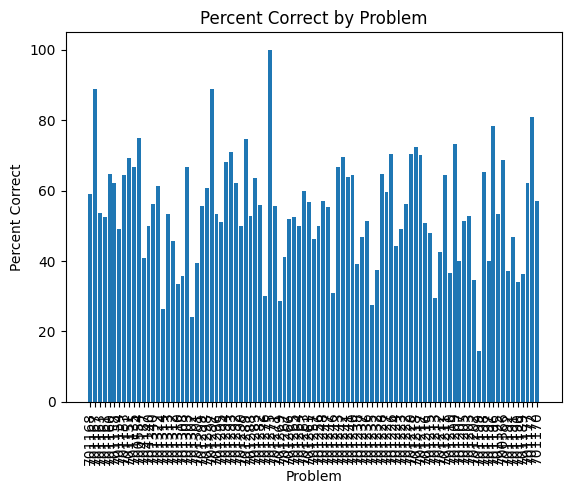

701168: 156
701167: 45
701163: 56
701161: 78
701160: 17
701158: 45
701154: 49
701153: 76
701151: 88
701135: 27
700554: 16
704187: 22
704140: 32
701340: 16
701322: 142
701314: 72
701313: 75
701312: 35
701310: 15
701308: 53
701303: 15
701302: 29
701301: 152
701299: 45
701298: 74
701297: 71
701296: 73
701295: 43
701294: 25
701293: 31
701292: 37
701290: 56
701289: 75
701288: 150
701283: 74
701282: 43
701276: 20
701275: 9
701271: 45
701269: 14
701267: 17
701266: 25
701265: 21
701264: 14
701263: 20
701261: 44
701257: 39
701256: 22
701248: 7
701247: 38
701246: 13
701243: 39
701242: 23
701241: 58
701240: 45
701238: 51
701237: 79
701236: 37
701235: 51
701232: 24
701228: 48
701227: 72
701226: 37
701224: 34
701223: 51
701222: 80
701220: 64
701218: 87
701217: 140
701216: 55
701215: 71
701213: 95
701212: 33
701211: 45
701210: 85
701209: 30
701208: 0
701207: 45
701205: 39
701204: 0
701203: 87
701202: 58
701199: 21
701198: 26
701197: 50
701196: 23
701195: 62
700366: 16
701192: 54
701191: 62
701190: 5

In [15]:
problemsResults = {}




for problem in problems:
    #problemResults[problem] = [correctInt, incorrectInt]
    problemsResults[problem] = {}
    problemsResults[problem]['correct'] = 0
    problemsResults[problem]['incorrect'] = 0
    problemsResults[problem]['indiffrent'] = 0
    problemsResults[problem]['total'] = len(problems[problem])
    problemsResults[problem]['correctPercent'] = 0
    problemsResults[problem]['correctFromSolvedPercent'] = 0

    good = 0
    bad = 0
    for user in problems[problem]:
        if (testUser(problems[problem][user])):
            good += 1
            problemsResults[problem]['correct'] += 1
        elif (testUser(problems[problem][user]) == False):
            bad += 1
            problemsResults[problem]['incorrect'] += 1
        else:
            problemsResults[problem]['indiffrent'] += 1
    try:
        problemsResults[problem]['correctPercent'] = problemsResults[problem]['correct'] / problemsResults[problem]['total'] * 100
        problemsResults[problem]['correctFromSolvedPercent'] = problemsResults[problem]['correct'] / (problemsResults[problem]['correct'] + problemsResults[problem]['incorrect']) * 100
    except:
        problemsResults[problem]['correctPercent'] = 0
        problemsResults[problem]['correctFromSolvedPercent'] = 0

    problemResultsLazyWay[problem] = {}
    problemResultsLazyWay[problem]["correctAnswerMean"] = listOfCorrectAnswerValues
    problemResultsLazyWay[problem]["incorrectAnswerMean"] = listOfIncorrectAnswerValues
    problemResultsLazyWay[problem]["indeterminateAnswerMean"] = listOfIndeterminateAnswerValues

    listOfCorrectAnswerValues = []
    listOfIncorrectAnswerValues = []
    listOfIndeterminateAnswerValues = []

print (problemsResults)

#bar graph of presentages
x = []
y = []
for problem in problemsResults:
    if problemsResults[problem]['correctPercent'] == 0:
        continue
    x.append(problem)
    y.append(problemsResults[problem]['correctFromSolvedPercent'])
plt.bar(x, y)
plt.xticks(rotation=90)
plt.ylabel('Percent Correct')
plt.xlabel('Problem')
plt.title('Percent Correct by Problem')
plt.show()

#print all lengths
for problem in problems:
    print (problem + ': ' + str(problemsResults[problem]['correct'] + problemsResults[problem]['incorrect']))

#print how many are above 50%
above50 = 0
below50 = 0
at50 = 0

avgAbove50 = 0
avgBelow50 = 0
for problem in problems:
    
    
    if (problemsResults[problem]['correctFromSolvedPercent'] == 0):
        pass
    elif problemsResults[problem]['correctFromSolvedPercent'] > 50:
        above50 += 1
        avgAbove50 += problemsResults[problem]['correctFromSolvedPercent']
    elif problemsResults[problem]['correctFromSolvedPercent'] < 50:
        below50 += 1
        avgBelow50 += problemsResults[problem]['correctFromSolvedPercent']
    elif problemsResults[problem]['correctFromSolvedPercent'] == 50:
        at50 += 1
    

        

avgAbove50 = avgAbove50 / above50
avgBelow50 = avgBelow50 / below50


print ('Above 50%: ' + str(above50))
print ('Below 50%: ' + str(below50))
print ('At 50%: ' + str(at50))
print ('Avg Above 50%: ' + str(avgAbove50))
print ('Avg Below 50%: ' + str(avgBelow50))
print ('Total: ' + str(above50 + below50))





{'701168': {'correct': 92, 'incorrect': 64, 'indiffrent': 17, 'total': 173, 'correctPercent': 53.179190751445084, 'correctFromSolvedPercent': 58.97435897435898}, '701167': {'correct': 40, 'incorrect': 5, 'indiffrent': 30, 'total': 75, 'correctPercent': 53.333333333333336, 'correctFromSolvedPercent': 88.88888888888889}, '701163': {'correct': 30, 'incorrect': 26, 'indiffrent': 29, 'total': 85, 'correctPercent': 35.294117647058826, 'correctFromSolvedPercent': 53.57142857142857}, '701161': {'correct': 41, 'incorrect': 37, 'indiffrent': 16, 'total': 94, 'correctPercent': 43.61702127659575, 'correctFromSolvedPercent': 52.56410256410257}, '701160': {'correct': 11, 'incorrect': 6, 'indiffrent': 14, 'total': 31, 'correctPercent': 35.483870967741936, 'correctFromSolvedPercent': 64.70588235294117}, '701158': {'correct': 28, 'incorrect': 17, 'indiffrent': 3, 'total': 48, 'correctPercent': 58.333333333333336, 'correctFromSolvedPercent': 62.22222222222222}, '701154': {'correct': 24, 'incorrect': 25,

KeyError: 701322

In [16]:
totalCorrect = 0
totalIncorrect = 0
totalIndifferent = 0
totalProblems = 0
for problem in problems:
    totalCorrect += problemsResults[problem]['correct']
    totalIncorrect += problemsResults[problem]['incorrect']
    totalIndifferent += problemsResults[problem]['indiffrent']
    totalProblems += problemsResults[problem]['total']

print ('Total Correct: ' + str(totalCorrect))
print ('Total Incorrect: ' + str(totalIncorrect))
print ('Total Indifferent: ' + str(totalIndifferent))
print ('Total Problems: ' + str(totalProblems))
print ('Total Percent Correct: ' + str(totalCorrect / totalProblems * 100))
print ('Total Percent From Solved: ' + str(totalCorrect / (totalCorrect + totalIncorrect) * 100))
print ('Total Percent Indifferent: ' + str(totalIndifferent / totalProblems * 100))




Total Correct: 2565
Total Incorrect: 2178
Total Indifferent: 1186
Total Problems: 5929
Total Percent Correct: 43.26193287232248
Total Percent From Solved: 54.079696394686906
Total Percent Indifferent: 20.003373250126497


Above 50%: 58
Below 50%: 33
At 50%: 20
Avg Above 50%: 63.41941816730808
Avg Below 50%: 34.99163494903696
Total: 91


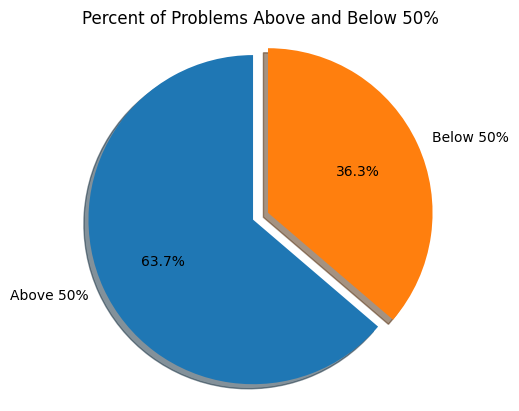

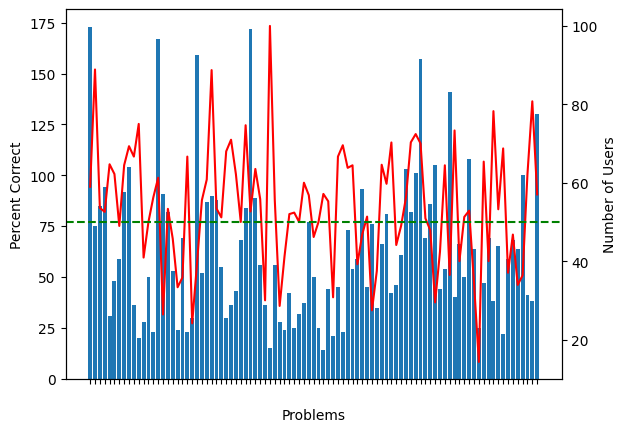

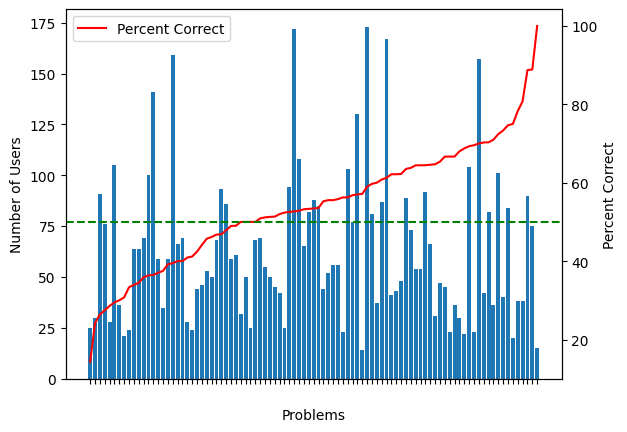

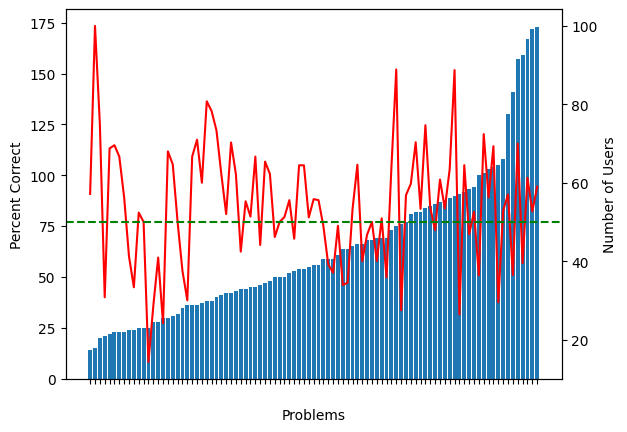

In [20]:
above50=0
below50=0
avgAbove50 = 0
avgBelow50 = 0
for problem in problems:
    if problemsResults[problem]['correctFromSolvedPercent'] > 50:
        above50 += 1
        avgAbove50 += problemsResults[problem]['correctFromSolvedPercent']
    elif problemsResults[problem]['correctFromSolvedPercent'] < 50:
        below50 += 1
        avgBelow50 += problemsResults[problem]['correctFromSolvedPercent']
    else:
        at50 += 1

avgAbove50 = avgAbove50 / above50
avgBelow50 = avgBelow50 / below50


print ('Above 50%: ' + str(above50))
print ('Below 50%: ' + str(below50))
print ('At 50%: ' + str(at50))
print ('Avg Above 50%: ' + str(avgAbove50))
print ('Avg Below 50%: ' + str(avgBelow50))
print ('Total: ' + str(above50 + below50))

#Generate a pie chart of the number of problems above 50% and below 50%
labels = 'Above 50%', 'Below 50%'
sizes = [above50, below50]
explode = (0, 0.1)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Percent of Problems Above and Below 50%')
plt.show()

#Generate a plot chart for number of users vs percent correct
x = []
y = []
z = []
for problem in problemsResults:
    if problemsResults[problem]['correctFromSolvedPercent'] == 0:
        continue
    x.append(problem)
    y.append(problemsResults[problem]['total'])
    z.append(problemsResults[problem]['correctFromSolvedPercent'])
plt.bar(x, y)
plt.ylabel('Percent Correct')
plt.xlabel('Problems')
#hide the x labels
plt.xticks(alpha=0)

#add another y axsis for percent correct
plt.twinx()
plt.plot(x, z, color='r')
plt.ylabel('Number of Users')
#draw a line at 50%
plt.axhline(y=50, color='g', linestyle='--')
plt.show()



#Same chart as above, but sorted by number of users
x = []
y = []
z = []
for problem in problemsResults:
    if problemsResults[problem]['correctFromSolvedPercent'] == 0:
        continue
    x.append(problem)
    y.append(problemsResults[problem]['total'])
    z.append(problemsResults[problem]['correctFromSolvedPercent'])
#sort by number of users
sortedIndex = np.argsort(z)
x = np.array(x)[sortedIndex]
y = np.array(y)[sortedIndex]
z = np.array(z)[sortedIndex]

plt.bar(x, y)
plt.ylabel('Number of Users')
plt.xlabel('Problems')
#hide the x labels
plt.xticks(alpha=0)

#add another y axsis for percent correct
plt.twinx()
plt.plot(x, z, color='r')
plt.ylabel('Percent Correct')

plt.legend(['Percent Correct'])

#draw a line at 50%
plt.axhline(y=50, color='g', linestyle='--')
plt.show()


#Same chart as above, but sorted by number of users
x = []
y = []
z = []
for problem in problemsResults:
    if problemsResults[problem]['correctFromSolvedPercent'] == 0:
        continue
    x.append(problem)
    y.append(problemsResults[problem]['total'])
    z.append(problemsResults[problem]['correctFromSolvedPercent'])
#sort by number of users
sortedIndex = np.argsort(y)
x = np.array(x)[sortedIndex]
y = np.array(y)[sortedIndex]
z = np.array(z)[sortedIndex]

plt.bar(x, y)
plt.ylabel('Percent Correct')
plt.xlabel('Problems')
#hide the x labels
plt.xticks(alpha=0)

#add another y axsis for percent correct
plt.twinx()
plt.plot(x, z, color='r')
plt.ylabel('Number of Users')
#draw a line at 50%
plt.axhline(y=50, color='g', linestyle='--')
plt.show()

In [44]:
print("Average correct score: ", np.mean(listOfCorrectAnswerValues + listOfIndeterminateAnswerValues))
print("Average incorrect score: ", np.mean(listOfIncorrectAnswerValues+ listOfIndeterminateAnswerValues))
print("Average indeterminate score: ", np.mean(listOfIndeterminateAnswerValues))

averageDiffBetweenCorrectAndIncorrect = []
for problem in problemResultsLazyWay:
    if problemResultsLazyWay[problem]["correctAnswerMean"] and problemResultsLazyWay[problem]["incorrectAnswerMean"]:
        print(problem + ': ' + str(np.mean(problemResultsLazyWay[problem]["correctAnswerMean"])))
        print(problem + ': ' + str(np.mean(problemResultsLazyWay[problem]["incorrectAnswerMean"])))
        print(problem + ': ' + str(np.mean(problemResultsLazyWay[problem]["indeterminateAnswerMean"])))
        averageDiffBetweenCorrectAndIncorrect.append(np.mean(problemResultsLazyWay[problem]["correctAnswerMean"]) - np.mean(problemResultsLazyWay[problem]["incorrectAnswerMean"]))

print("Average difference between correct and incorrect: ")
print(averageDiffBetweenCorrectAndIncorrect)
print("Overall average difference: ", np.mean(averageDiffBetweenCorrectAndIncorrect))

#plot the average difference between correct and incorrect bar graph line at 0
x = []
for i in range(len(averageDiffBetweenCorrectAndIncorrect)):
    x.append(i)
plt.bar(x, averageDiffBetweenCorrectAndIncorrect)
plt.axhline(0, color='r', linestyle='--')
plt.ylabel('Average Difference')
plt.xlabel('Problems')
plt.title('Average Difference Between Correct and Incorrect')
plt.show()


Average correct score:  nan
Average incorrect score:  nan
Average indeterminate score:  nan
701168: 30.542181
701168: 26.403421
701168: 28.267124
701167: 36.36088
701167: 51.74468
701167: 31.54951
701163: 48.69254
701163: 49.205364
701163: 51.68582
701161: 43.5898
701161: 43.66947
701161: 40.53216
701160: 55.34482
701160: 56.810276
701160: 56.743572
701158: 44.291912
701158: 45.549187
701158: 61.72023
701154: 47.683884
701154: 43.85921
701154: 47.69353
701153: 50.872112
701153: 51.02564
701153: 49.505493
701151: 40.317673
701151: 41.547207
701151: 51.02489
701135: 47.69788
701135: 48.17029
701135: 50.566395
700554: 48.29359
700554: 44.840275
700554: 53.23842
704187: 37.83169
704187: 34.372757
704187: 42.00248
704140: 50.86717
704140: 47.715942
704140: 49.246475
701340: 48.22487
701340: 41.976654
701340: 47.331642
701322: 51.733883
701322: 49.97765
701322: 54.801678
701314: 50.638
701314: 42.136143
701314: 38.961044
701313: 35.221943
701313: 31.881636
701313: 40.95413
701312: 53.802612


/home/mcall/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mcall/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


TypeError: bar() missing 1 required positional argument: 'height'

In [ ]:
#Simple test, check the first answer and last answer and see if the last answer is higher
max_length = model.layers[0].input_shape[0][1]
print (max_length)
def testUser(user):
    if user[0][0]:
        return None,None
    #expected input, a list of lists, each list is [boolifCorrect, answer]
    #expected output, a bool if the last answer is higher than the first answer
    #get the first answer that is incorrect
    firstAnswer = ''
    for answer in user:
        if not answer[0]:
            firstAnswer = answer[1]
            break
    #get the last answer that is correct
    lastAnswer = ''
    for answer in reversed(user):
        if answer[0]:
            lastAnswer = answer[1]
            break

    
    firstAnswerScore = 0
    lastAnswerScore = 0


    #convert both to model ready input
    if (firstAnswer == '') or (lastAnswer == ''):
        return None, None
    firstAnswer = TokenizerManager.tokenStartFromString(firstAnswer, tokenizerModel)
    lastAnswer = TokenizerManager.tokenStartFromString(lastAnswer, tokenizerModel)
    #pad both
    firstAnswer = pad_sequences([firstAnswer[0]], maxlen= max_length)
    lastAnswer = pad_sequences([lastAnswer[0]], maxlen=max_length)
    #get the scores
    firstAnswerScore = model.predict([firstAnswer], verbose=0)
    print(firstAnswerScore)
    lastAnswerScore = model.predict([lastAnswer], verbose=0)
    print(lastAnswerScore)
    #return if the last answer is higher
    


    if lastAnswerScore == firstAnswerScore:
        listOfIndeterminateAnswerValues.append(firstAnswerScore[0][0])
        return None, None
    listOfCorrectAnswerValues.append(firstAnswerScore[0][0])
    listOfIncorrectAnswerValues.append(lastAnswerScore[0][0])
    return firstAnswerScore[0][0], lastAnswerScore[0][0]


#Statistical Analysis of selected problem.
ProblemToProcess = problems["701170"]
CorrectScores = []
IncorrectScores = []

CorrectValScores = []
IncorrectValScores = []
ValidationSetSize = int(len(ProblemToProcess) / 3)

for i in range(ValidationSetSize):
    user = random.choice(list(ProblemToProcess.keys()))
    correct, incorrect = testUser(ProblemToProcess[user])
    if correct:
        CorrectValScores.append(correct)
    if incorrect:
        IncorrectValScores.append(incorrect)
    #remove the user from the list
    del ProblemToProcess[user]


for user in ProblemToProcess:
    correct, incorrect = testUser(ProblemToProcess[user])
    if correct:
        CorrectScores.append(correct)
    if incorrect:
        IncorrectScores.append(incorrect)



#get how many correct scores are above 54.537323
above = 0
for score in CorrectScores:
    if score > 54.80999999999705:
        above += 1

print("Correct Scores Above 54.537323: ", above)

#get how many incorrect scores are below 54.537323
below = 0
for score in IncorrectScores:
    if score < 54.80999999999705:
        below += 1

print("Incorrect Scores Below 54.537323: ", below)

optimalScore = 0
previousPerformance = 0
for score in np.arange(40,60,.01):
    above = 0
    below = 0
    for scoreA in CorrectScores:
        if scoreA > score:
            above += 1
    for scoreA in IncorrectScores:
        if scoreA < score:
            below += 1
    if above + below > previousPerformance:
        optimalScore = score
        previousPerformance = above + below

print ("Optimal Score: ", optimalScore)
print ("Performance: ", previousPerformance)


#validate the optimal score
above = 0
aboveIncorrect = 0
below = 0
belowIncorrect = 0
for score in CorrectValScores:
    if score > optimalScore:
        above += 1
    else:
        aboveIncorrect += 1
for score in IncorrectValScores:
    if score < optimalScore:
        below += 1
    else:
        belowIncorrect += 1

print("Correct Scores Above Optimal Score: ", above)
print("Incorrect Scores Below Optimal Score: ", below)
print("Percentage of Correct Scores Above Optimal Score: ", above / len(CorrectValScores) * 100)
print("Percentage of Incorrect Scores Below Optimal Score: ", below / len(IncorrectValScores) * 100)

print("Percentage Categorized Correct: ", (above + below) / (len(CorrectValScores) + len(IncorrectValScores)) * 100)





500
[[42.529037]]
[[47.305473]]
[[47.47274]]
[[50.298923]]
[[44.86647]]
[[49.3827]]
[[54.94953]]
[[47.626785]]
[[43.485172]]
[[54.369583]]
[[62.170666]]
[[59.51976]]
[[55.309647]]
[[55.309647]]
[[61.235588]]
[[54.369583]]
[[58.866383]]
[[59.692253]]
[[26.281609]]
[[54.354378]]
[[51.650032]]
[[49.76272]]
[[56.78826]]
[[56.74865]]
[[55.310223]]
[[47.062885]]
[[59.889122]]
[[59.722168]]
[[57.118393]]
[[54.369583]]
[[57.12522]]
[[45.216286]]
[[55.25664]]
[[56.57584]]
[[37.225876]]
[[51.000008]]
[[56.54003]]
[[55.34527]]
[[20.97218]]
[[62.34247]]
[[59.51976]]
[[58.773975]]
[[48.03741]]
[[54.369583]]
[[49.76272]]
[[49.76272]]
[[57.73581]]
[[49.217987]]
[[47.73181]]
[[47.731945]]
[[36.4132]]
[[54.369583]]
[[44.6403]]
[[42.067314]]
[[62.154823]]
[[61.431587]]
[[41.184185]]
[[49.76272]]
[[51.178047]]
[[45.10539]]
[[55.25664]]
[[57.14956]]
[[55.668884]]
[[49.567646]]
[[42.57834]]
[[54.369583]]
[[40.544136]]
[[54.41738]]
[[44.86647]]
[[49.217987]]
[[59.623722]]
[[54.369583]]
[[41.555836]]
[[49.21